In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import r2_score

In [3]:
train = pd.read_csv('/content/drive/MyDrive/Final Project/pre_processed_train.csv')
train = train.rename(columns={train.columns[0]: 'index'})

In [4]:
test = pd.read_csv('/content/drive/MyDrive/Final Project/pre_processed_test.csv', chunksize=1)

# **Create vectors of features to find cosine similarity between them**

In [5]:
def get_feature_vectors(data):
    first_list = list(data.columns[2:11])
    second_list = list(data.columns[24:31])
    features = first_list + second_list

    feature_data = data[features]

    feature_vectors = feature_data.values.tolist()

    result_df = data.copy()
    result_df['Feature_Vector'] = feature_vectors

    return result_df

# **Pre_processed train data is supposed to have its feature vectors at the end column.**

In [ ]:
#train = get_feature_vectors(train)
#train.to_csv('/content/drive/MyDrive/Final Project/pre_processed_train.csv', index=False)

# **There are strict feature which train and test data must have same. This is for example 'meal_time', when someone asks dinner, breakfast should not be recomended even other features are similar. of if someone requires drinks meal should not be suggested**

In [6]:
def filter_train(train, test):
    columns_to_check = ['meal_time', 'is_supplement', "is_drinks", "is_workout"]
    test_values = test[columns_to_check].values
    matched_indices = []
    for test_row in test_values:
        mask = (train[columns_to_check] == test_row).all(axis=1)
        matched_indices.extend(train[mask].index.tolist())

    matched_indices = list(set(matched_indices))

    filtered_train = train.loc[matched_indices]

    return filtered_train

# **This function is for visualization if where is customer and simmilar user on the graph**

In [7]:
def plot_feature_vectors(train_vectors, test_vectors, similar_user_index, original_train_indexes):
    pca = PCA(n_components=2)
    all_vectors = np.vstack((train_vectors, test_vectors))
    pca_result = pca.fit_transform(all_vectors)

    train_pca = pca_result[:len(train_vectors)]
    test_pca = pca_result[len(train_vectors):]

    similar_user_pca = None
    if similar_user_index in original_train_indexes:
        index_in_pca = original_train_indexes.index(similar_user_index)
        similar_user_pca = train_pca[index_in_pca]

    plt.figure(figsize=(12, 8))

    plt.scatter(train_pca[:, 0], train_pca[:, 1], c='blue', label='Train Vectors', edgecolor='k', s=50, alpha=0.7)

    plt.scatter(test_pca[:, 0], test_pca[:, 1], c='red', label='Test Vectors', edgecolor='k', s=200, alpha=0.7)

    if similar_user_pca is not None:
        plt.scatter(similar_user_pca[0], similar_user_pca[1], c='green', label='Similar User', marker='X', s=150, edgecolor='k', alpha=0.9)
        plt.annotate(f'Similar User', (similar_user_pca[0], similar_user_pca[1]),
                     xytext=(0.1, 0.2), ha='center', fontsize=12,
                     arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=0.3'))

    for i, (x, y) in enumerate(test_pca):
        plt.annotate(f'Test', (x, y),
                     xytext=(0.1, 0.4), ha='center', fontsize=12,
                     arrowprops=dict(facecolor='black', arrowstyle='->', connectionstyle='arc3,rad=0.3'))

    plt.title('PCA of Train and Test Feature Vectors')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# **This function gets simmilar users and runs all above functions**

In [19]:
def get_similar_users(train, test, recommended_items, top_n=10, plot=False):
    filtered_train = filter_train(train, test)

    filtered_train_with_vectors = get_feature_vectors(filtered_train)
    test_with_vectors = get_feature_vectors(test)

    train_vectors = np.array(filtered_train_with_vectors['Feature_Vector'].tolist())
    test_vectors = np.array(test_with_vectors['Feature_Vector'].tolist())

    original_train_indexes = filtered_train_with_vectors.index.tolist()

    similar_users_indices = []
    for test_vector in test_vectors:
        similarities = cosine_similarity([test_vector], train_vectors)
        top_indices = np.argsort(similarities.flatten())[-top_n:]
        top_indices = top_indices[np.argsort(similarities.flatten()[top_indices])[::-1]]
        similar_users_indices.extend(top_indices.tolist())

    similar_users_indices = list(set(original_train_indexes[i] for i in similar_users_indices))
    similar_users_df = filtered_train.loc[similar_users_indices]
    if recommended_items == 1:
      most_similar_user_index = similar_users_df['success_index'].idxmin()
      most_similar_user = similar_users_df.loc[most_similar_user_index]
    else:
      most_similar_user_index = similar_users_df['success_index'].sort_values(ascending=False).head(recommended_items).index
      most_similar_user = similar_users_df.loc[most_similar_user_index]

    if plot:
        plot_feature_vectors(train_vectors, test_vectors, most_similar_user_index, original_train_indexes)

    return most_similar_user

# **Here is sugesstion of meal and evaluation of the model**

In [93]:
def get_predictions_result(test, print_dish = False, plot = False, recommended_items = 1):
  test_chunks = test.get_chunk(1)
  if recommended_items == 1:
    similar_users = get_similar_users(train, test_chunks, recommended_items, top_n=100, plot = plot)
  else:
    similar_users = get_similar_users(train, test_chunks, recommended_items, top_n=100, plot = plot)
  actual_values = test_chunks[['Calories_value', 'Carbs_value', 'Fat_value', 'Protein_value', 'Sodium_value', 'Sugar_value']].values.flatten()

  predicted_values_list = [similar_users[col].mean() for col in ['Calories_value', 'Carbs_value', 'Fat_value', 'Protein_value', 'Sodium_value', 'Sugar_value']]
  predicted_values_array = np.array(predicted_values_list)
  actual_values_array = np.array(actual_values)

  r2 = r2_score(actual_values_array, predicted_values_array)
  if print_dish:
    print('----------------------------------------------------------')
    if recommended_items == 1:
      print(f"Predicted value: |{similar_users.DishName}|")
    else:
      print(f"Predicted values: ")
      for i, j in enumerate(similar_users.DishName.to_list()):
        print(i + 1,"-", j)
    print('----------------------------------------------------------')
    print(f"Actual values: |{test_chunks.DishName.values[0]}|")
    print('----------------------------------------------------------')
    print(f"R square score is: {r2}")
    print('----------------------------------------------------------')
  else:
    return r2

# **Here we can measure r square for several row and then get average for producing more accurate result.**

In [10]:
def get_score(n = 10):
  score_lst = []
  for i in range(n):
    score_lst.append(get_predictions_result(test))
  return np.mean(score_lst)

In [11]:
get_score(5)

0.9054634873722177

# **Here the result is the evaluation score, dishname and visualization of how far our user is from similar user.**

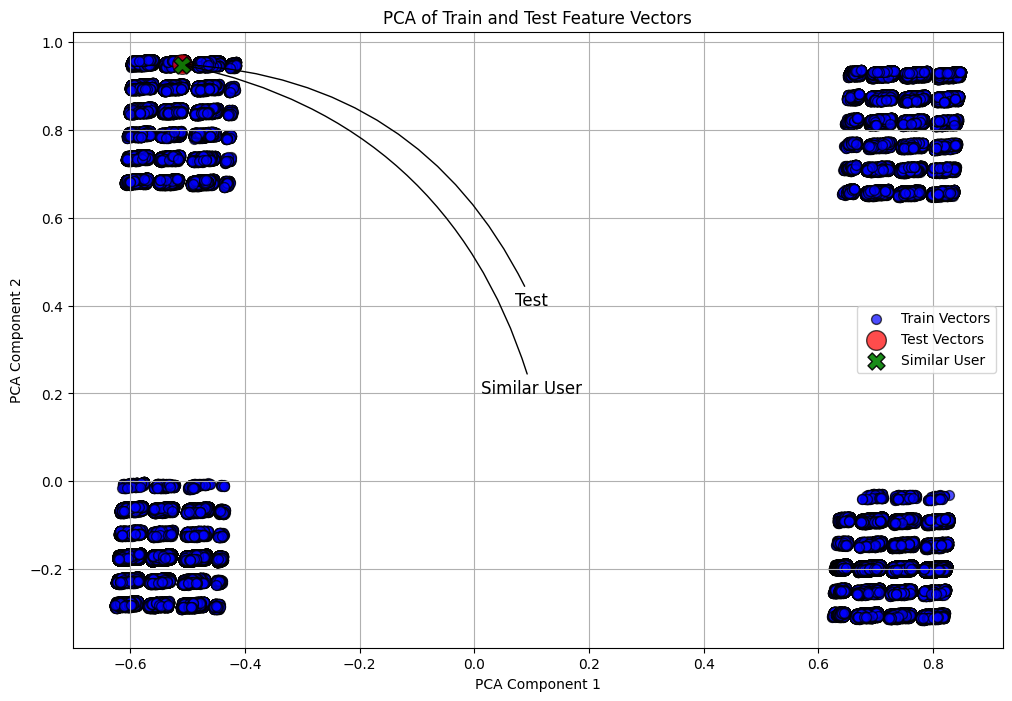

----------------------------------------------------------
Predicted value: |Rice - White, long-grain, regular, cooked, 1 cup|
----------------------------------------------------------
Actual values: |my - McDonalds Espresso Pronto® Flat White, 1 TALL|
----------------------------------------------------------
R square score is: 0.9446560299272224
----------------------------------------------------------


In [97]:
get_predictions_result(test, print_dish=True, plot = True)

In [96]:
%time get_predictions_result(test, print_dish=True, plot=False, recommended_items=30)

----------------------------------------------------------
Predicted values: 
1 - Mrm - Veggie Protein, 1 scoop
2 - Mrm - Veggie Protein, 1 scoop
3 - Dole - Banana - Small Organic, 0.5 small
4 - Almond Breeze - Unsweetened Original Almond Milk, 240 ml
5 - Sweet potato - Cooked, candied, home-prepared (Sweetpotato), 100 g
6 - Home Made (All Recipes) - Banana Banana Bread, 2 slice
7 - Aunt Jemima - Syrup (Corrected), 1/8 cup
8 - Eggs - Hard-boiled (whole egg), 2 large
9 - Chobani - Greek Yogurt - 2% Mango, 5.3 oz (150g)
10 - Dunkin Donuts - Chocolate Munchkins, 3 hole
11 - Dunkin Donuts - Salted Caramel Hot Chocolate - Medium, 14 fl oz
12 - Boulange Des Campagnards - Pain 12 Grains Style Belge, 4 tranches (64g)
13 - Kraft - Singles thin cheese slices, 1 slice
14 - Café - Café Noir, 1 cup
15 - Kraft - Peanut Butter Smooth/cremeux, 1 Tbsp (15g)
16 - Compliments - Hash Brown Fried Potatoes No Trans Fat, 3/4 cup (85 g)
17 - Becel - Margarine Becel, 1 tsp. (10g)
18 - Oeuf Large - 1 Oeuf Large

# **This is actual value of what customer chose**

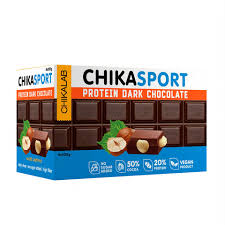

# **This is what model recomends**

Nestle-Coffeemate-Caramel-Latte-Coffee-Creamer-15-oz_514dc94f-0088-4a10-b5aa-7f170f30bbc4.9641b06a28a1c1a1137261a3a32b3990.avif